### Importing libraries and setting up directories to prepare data for preprocess.py script

We need landsat images and labels to cover the same extent in order to pass the data tot he preprocess pipeline and then to the model. This notebook steps through the functions necessary to munge labels to fit the Landsat tile extent of interest. More work will need to be done to prepare data across multiple tiles for MaskRCNN.

In [28]:
import os
import sys
import random
import numpy as np
import skimage.io as skio
import matplotlib
import matplotlib.pyplot as plt
import copy
from skimage import measure
import rasterio
import rasterio.features
import rasterio.warp
import geopandas as gpd
import shapely as shp
from shapely.geometry import Polygon
import rasterio
import rasterio.env
%matplotlib inline

# Root directory of the project
ROOT_DIR = os.path.abspath("/home/rave/tana-crunch/waves/cropmask/data/")

TILE_LABELS_DIR = os.path.join(ROOT_DIR, 'north_platte_landsat_tile_labels')
# first run for f in *; do tar -zxvf $f -C ./ && rm $f; done
# if in .tar.gz 
ORIGINAL_LABELS_DIR = os.path.join(ROOT_DIR, 'original_nebraska_labels')
LANDSAT_ARCHIVE_DIR = os.path.join(ROOT_DIR, 'North_Platte_Western_NB_L5_2004-2006')
LANDSAT_STACKED_DIR = os.path.join(ROOT_DIR, 'North_Platte_Western_NB_L5_2004-2006_stacked') # directory of Landsat imgs where bands for an acquisition in one tif

try:
    os.mkdir(ORIGINAL_LABELS_DIR)
    os.mkdir(LANDSAT_ARCHIVE_DIR)
    os.mkdir(LANDSAT_STACKED_DIR)
    os.mkdir(TILE_LABELS_DIR)
except:
    FileExistsError

os.chdir(ROOT_DIR)

In [29]:
def raster_to_polygon(directory, scene_id, epsg_string='EPSG:32613'):
    """
    Finds the extent of a raster (the valid data extent not the bbox) and
    returns as a shapely polygon.
    """
    #get a raster of the path/row/date of interest to get data extent
    with rasterio.open(os.path.join(directory, scene_id+"_01_T1_sr_band1.tif")) as dataset:
        mask = dataset.dataset_mask()
    # Extract feature shapes and values from the array.
        for geom, val in rasterio.features.shapes(
                mask, transform=dataset.transform):
            # Transform shapes from the dataset's own coordinate
            # reference system to CRS84 (EPSG:4326).
            if val == 255:
                geom = rasterio.warp.transform_geom(
                    dataset.crs, epsg_string, geom, precision=12)
    return Polygon(geom['coordinates'][1]) # 0th element is the bbox

Each data extent of a landsat tile differs, even within the same path/row there is a slight drift. Therefore we get the data extent on a per scene basis to get the corresponding labels. This needs to be run in a long for loop, probably multiprocessed, for each landsat scene id. 

Some scene ids also look really really bad even if they meet the criteria of having less than 10% clouds, so future order requests should probably be more sonservative. Might need to apply clud script cloud masking functions to mask clouds and the labels that correspond to areas that are masked

In [16]:
scene_id = "LT05_L1TP_032031_20040926_20160913"

In [12]:
polygon_20040926 = raster_to_polygon(LANDSAT_ARCHIVE_DIR, scene_id)

In [13]:
pivots_df = gpd.read_file(os.path.join(ORIGINAL_LABELS_DIR,"AnalyzedPivots_GM.shp"))
pivots_df.to_crs(epsg=32613, inplace=True)


In [14]:
def intersect_polygon_multipolygons(df, polygon):
    """
    intersects a df of labels and a polygon of a raster tile and
    returns a df containing the label geometries that intersect
    """
    
    geodf = gpd.GeoDataFrame()
    for i in range(0, df['ObjectID'].count()): # need to make a row entry for each cp to do intersection (super inefficient)
        geodf.loc[i,'geometry'] = polygon
    return df[df.intersects(geodf)]

In [15]:
labels_20040926= intersect_polygon_multipolygons(pivots_df, polygon_20040926)

In [30]:
labels_20040926.to_file(filename=os.path.join(TILE_LABELS_DIR,scene_id+"_labels.geojson"), driver="GeoJSON")

These tiles have  a lot of overlap, only using a single full tile for the preprocessing/modeling

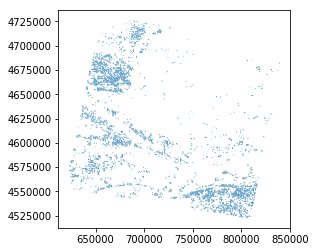

In [26]:
labels_20040926.plot() # full scene, good

This scene_ids_from_bands_list function can be used to get a list of scene ids that can be iterated over by the stack_and_save_rgb_rasterio function

In [18]:
def scene_ids_from_bands_list(directory):
    bands = os.listdir(LANDSAT_ARCHIVE_DIR)
    for i,b in enumerate(bands):
        bands[i] = b[0:37]
    scenes = np.unique(bands)
    return scenes

In [25]:
def stack_and_save_rgb_rasterio(scene_id, src_directory, dst_directory, stack_type= 'rgb'):
    """
    Takes a single scene id and extracts and stacks rgb bands. saves the new raster in the dst_dir
    To expand this to stack more bands, need to abstract the if 
    band statements.
    """
    bands = sorted(os.listdir(src_directory))
    with rasterio.Env():
        bgr = [os.path.join(src_directory,band) for band in [band for band in bands if scene_id in band] if "band1" in band or "band2" in band or "band3" in band]
        rgb_scene = np.stack([skio.imread(bgr[0]),skio.imread(bgr[1]),skio.imread(bgr[2])], axis=0)
        src = rasterio.open(bgr[0])
        profile = src.profile.copy()
        profile.update(count=3)
        with rasterio.open(os.path.join(dst_directory,scene_id+'_'+stack_type+'.tif'), 'w', **profile) as dst:
            dst.write(rgb_scene)
stack_and_save_rgb_rasterio(scene_id, LANDSAT_ARCHIVE_DIR, LANDSAT_STACKED_DIR)